# python 에 필요한 module 불러오기

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from math import exp

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import FinanceDataReader as fdr
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


# 특성(MA,Stochastic,rsi) 추가

In [2]:


#특성 추가 ------------------------------------------
    #이동평균선
def get_MA(df):
    MA_26=df["Close"].rolling(26).mean()
    MA_52=df["Close"].rolling(52).mean()
    df=df.assign(MA_26=MA_26,MA_52=MA_52).dropna()
    
    return df

    
    #스토캐스틱
def get_stochastic(df, n=15, m=5, t=3):
    # n일중 최고가
    ndays_high = df.High.rolling(window=n, min_periods=1).max()
    # n일중 최저가
    ndays_low = df.Low.rolling(window=n, min_periods=1).min()
 
    # Fast%K 계산
    kdj_k = ((df.Close - ndays_low) / (ndays_high - ndays_low))*100
    # Fast%D (=Slow%K) 계산
    kdj_d = kdj_k.ewm(span=m).mean()
    # Slow%D 계산
    kdj_j = kdj_d.ewm(span=t).mean()
 
    # dataframe에 컬럼 추가
    df = df.assign(kdj_k=kdj_k, kdj_d=kdj_d, kdj_j=kdj_j).dropna()
    
    return df


def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)
# Add Momentum_1D column for all 15 stocks.
# Momentum_1D = P(t) - P(t-1)


# 주식 데이터 불러오기

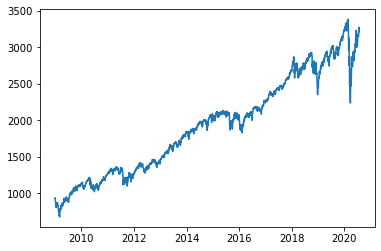

In [3]:
US5002 = fdr.DataReader("US500","2009-01-01")
plt.plot(US5002["Close"])

In [4]:
plt.plot(US500["Close"])

NameError: name 'US500' is not defined

In [ ]:
KS11 = fdr.DataReader("KS11","2009-01-01","2019-01-01") #코스피
KQ11= fdr.DataReader("KQ11","2009-01-01","2019-01-01") #코스닥
US500 = fdr.DataReader("US500","2009-01-01","2019-01-01") #SP500
HSI = fdr.DataReader("HSI","2009-01-01","2019-01-01") #항생지수
IXIC = fdr.DataReader("IXIC","2009-01-01","2019-01-01") #나스닥

KS11 = KS11.drop(['Volume'], axis = 1 )
KQ11 = KQ11.drop(['Volume'], axis = 1 )
US500 = US500.drop(['Volume'], axis = 1 )
HSI = HSI.drop(['Volume'], axis = 1 )
IXIC = IXIC.drop(['Volume'], axis = 1 )

# 사용될 변수 생성

In [ ]:
예측dic={}
수익률dic={}
End = 1 # 0이 되면 반복 종료
초기돈 = 10000
d,dd= 1, 20
BATCH = 20 # 리밸런싱 주기
count = 0 # 리밸런싱된 횟수 count
pred_dic={}
투자결과=[]
총df=pd.DataFrame()
총df2=pd.DataFrame()
그래프용={}
그래프용2={}
그래프용sum=0
all_df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"]) # 총 table
set_df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"]) # 20일 주기 table

# Main 모델

In [ ]:
plt.plot(KS11["Close"],label="KOSPI")
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('MA_26,MA_52 and close of KS11')
plt.plot()
MA_26=KS11["Close"].rolling(26).mean()
MA_52=KS11["Close"].rolling(52).mean()
plt.plot(MA_26,'k:',label='MA_26')
plt.plot(MA_52,'k',label='MA_52')
plt.legend()
fig = plt.gcf()
fig.savefig('ma1.png', dpi=fig.dpi)

2361

2380

(2380,)

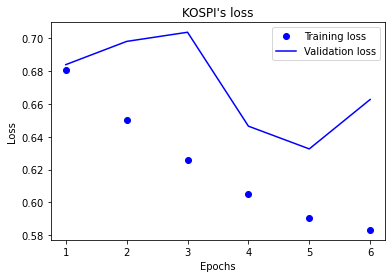

KOSPI 정확도 :  0.7236111111111111


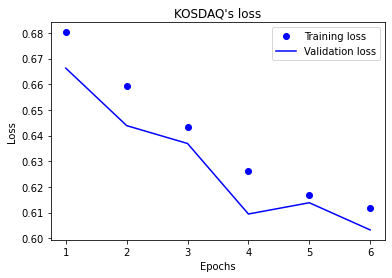

KOSDAQ 정확도 :  0.7069444444444445


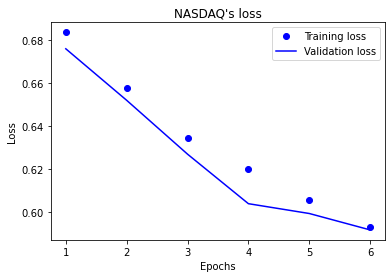

NASDAQ 정확도 :  0.7


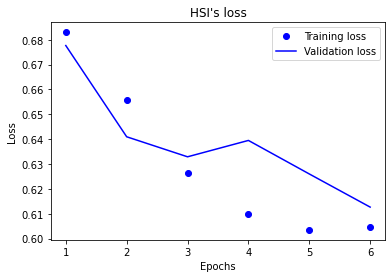

HSI 정확도 :  0.7263888888888889


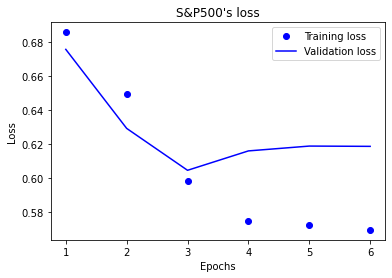

S&P500 정확도 :  0.7069444444444445
1~20일 차 ---------------------------------
분산 투자 :  [3325.1956631004527, 0, 3770.392189555198, 2926.983641645009, 0]
투자 결과 :  10022.57149430066
3 그래프용 sum!
21~40일 차 ---------------------------------
분산 투자 :  [0, 0, 0, 15135.233511473369, 0]
투자 결과 :  15135.233511473369
1 그래프용 sum!
41~60일 차 ---------------------------------
분산 투자 :  [15135.233511473369]
투자 결과 :  15135.233511473369
0 그래프용 sum!
61~80일 차 ---------------------------------
분산 투자 :  [7492.6006802905595, 0, 8018.983241743716, 0, 0]
투자 결과 :  15511.583922034275
2 그래프용 sum!
81~100일 차 ---------------------------------
분산 투자 :  [5412.693836579684, 5251.284121672123, 0, 5529.702126068172, 0]
투자 결과 :  16193.680084319978
3 그래프용 sum!
101~120일 차 ---------------------------------
분산 투자 :  [0, 0, 9034.056977362196, 0, 8747.840549393171]
투자 결과 :  17781.89752675537
2 그래프용 sum!
121~140일 차 ---------------------------------
분산 투자 :  [17781.89752675537]
투자 결과 :  17781.89752675537
0 그래프용 sum!
141~160일 차 -----------

In [113]:


for 인덱스,인덱스명 in zip([KS11,KQ11,IXIC,HSI,US500],["KOSPI","KOSDAQ","NASDAQ","HSI","S&P500"]):
    df = 인덱스
    
    # 특성 추가--------------------------------------------------------
    
    
        #스토캐스틱과 이동평균선
    df=get_stochastic(df)
    df=get_MA(df)
    
        #RSI
    df['Momentum_1D'] = (df['Close']-df['Close'].shift(1))
    df['RSI_14D'] = df['Momentum_1D'].rolling(center=False, window=14).apply(rsi)
    df=df.dropna()
    df=df[0:-(len(df)%BATCH)]
    df = df.drop(labels = ['Momentum_1D'], axis=1)
    
        #이동평균선
    MA_26=df["Close"].rolling(21).mean()
    df_MA=MA_26.dropna()
    df_char=df[20:] # df_char : 특성 모두 추가한 data, rolling,shifting 고려해서 제거
       #------------------------------------------------------------------
    
    
    
    
        # y ( target ) 생성 df_char= 값, df_MA= 이동평균선---------------------
    y=[]
    #20개로 1개 예측
    h=1
    for x in range(1,len(df_char)-20+1):
        if(df_char["Close"][x-1] > df_MA[20*h]):
            y.append(0)
        else:
            y.append(1)
        if(x%20==0):
            h=h+1

    df = df_char[:-20] 
    nparr = df # 스케일링 할 데이터
    nparr2 = df # 스케일링 안한 데이터 백업

    
    #normalizing
    scaler = MinMaxScaler(feature_range=(0, 1))
    df["Close"]=scaler.fit_transform(nparr["Close"].values.reshape(-1,1))
    df["Open"]=scaler.fit_transform(nparr["Open"].values.reshape(-1,1))
    df["High"]=scaler.fit_transform(nparr["High"].values.reshape(-1,1))
    df["Low"]=scaler.fit_transform(nparr["Low"].values.reshape(-1,1))
    df["Change"]=scaler.fit_transform(nparr["Change"].values.reshape(-1,1))
    df["kdj_k"]=scaler.fit_transform(nparr["kdj_k"].values.reshape(-1,1))
    df["kdj_d"]=scaler.fit_transform(nparr["kdj_d"].values.reshape(-1,1))
    df["kdj_j"]=scaler.fit_transform(nparr["kdj_j"].values.reshape(-1,1))
    df["MA_26"]=scaler.fit_transform(nparr["MA_26"].values.reshape(-1,1))
    df["MA_52"]=scaler.fit_transform(nparr["MA_52"].values.reshape(-1,1))
    df["RSI_14D"]=scaler.fit_transform(nparr["RSI_14D"].values.reshape(-1,1))
    
    #-----
#     df["y"]=y
#     print(df.corr()) #상관관계 분석 ( 출력하고 싶다면 주석 제거)
#     df = df.drop(['y'],axis = 1)
    #-----
    
    df = df.drop(['Close','Open','High','Low','MA_26','MA_52'], axis = 1 ) # 상관관계 분석 후 관계 적은 특성(열) 제거
    X=df.values
    
    # train test val 세팅
    setlen=int(len(X)/20*0.7)*20 # 데이터를 7:3으로 나누고 20의 배수로 만듬
    X_train=X[:setlen]
    X_test=X[setlen:]
    y_train=y[:setlen]
    y_test=y[setlen:]
    
    setlen2=int(len(X_train)/20*0.3)*20 # 검증 데이터를 3:7으로 나누고 20의 배수로 만듬
    X_val = X_train[ : setlen2]
    y_val = y_train[ : setlen2]
    X_train2 = X_train[setlen2 : ]
    y_train2 = y_train[setlen2 : ]
    
    
    # 딥러닝 모델에 맞는 사이즈로 전처리
    X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))
    
    X_val = np.reshape(X_val, (X_val.shape[0],1, X_val.shape[1]))
    X_train2 = np.reshape(X_train2, (X_train2.shape[0],1, X_train2.shape[1]))
    
    #LSTM모델 생성
    model = Sequential()
    model.add(LSTM(36, input_shape=(1, 5)))
    for i in range(2):
        model.add(Dense(18,activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train2, y_train2, epochs=6, batch_size=16,validation_data=(X_val,y_val),verbose=0)
    
    history_dict= history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['accuracy']
    epochs = range(1,len(acc)+1)

    plt.plot(epochs,loss_values,'bo',label='Training loss')
    plt.plot(epochs,val_loss_values,'b',label='Validation loss')
    plt.title("{}'s loss".format(인덱스명))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    pred=np.where(model.predict(X_test)>0.5,1,0)
    예측dic[인덱스명]=pred # 예측 데이터 table에 추가
    수익률dic[인덱스명]=nparr2["Close"][setlen:] #투자 결과를 보기 위해 실제 수익률을 구함

    print(인덱스명, "정확도 : ", accuracy_score(y_test,np.where(model.predict(X_test)>0.5,1,0)))
       
    #모델 생성 완료 ------------------------------

key="KOSPI" #오류방지 임시
 
while End==1: # 종료조건 ( END =0 )까지 반복
    

        if(len(수익률dic[key])==BATCH+20):
            End=0
            print("------------종료------------  ◆리밸런싱 수◆ : " , count)
            break
            #----------------------------------
        else:


            # 날짜 출력 ------   
            day= str(d) +"~" + str(dd) + "일 차"
            print(day,"---------------------------------")
            # --------------- 
            set_df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"])



            for key,val in zip(예측dic.keys(),예측dic.values()): 


                #----------------------- 지수함수로 중요 비중 조정
                e_sum = 0
                for xx in range(1,21):
                    e_sum=e_sum+exp(xx)

                pred_list=[]
                rank=1
                pred=val[BATCH-20:BATCH] # BATCH는 0부터 매 리밸런싱마다 20씩 증가

                for yy in pred:
                    pred_list.append(yy*rank)
                    rank = rank + 1       # ex ) [1,1,1,0,1,0,..] -> [1,2,3,0,5,0..] 로 가중치를 줌


                pred_sum=0
                for zz in pred_list:
                    pred_sum=pred_sum+(exp(zz)/e_sum) # 가중치를 e에 대입
                pred_sum=round(pred_sum,4) # 소수 4번째 반올림
                #--------------------------------------------------


                # 예측 결과를 표(dataframe)로 보기 쉽게 정리-----------------
                if count==0:
                    pred_dic[key]=pred_sum #pred_dic == {}
                else:
                    pred_dic[key]=np.append(pred_dic[key],pred_sum)
                예측 = pred_sum
                실제수익률 = ((수익률dic[key][BATCH+19])/(수익률dic[key][BATCH]))-1
                turn_df=pd.DataFrame(data={"영업일":[day],"인덱스":[key],"상승예측확률":[예측],"실제수익률":[실제수익률] }, columns=["영업일","인덱스","상승예측확률","실제수익률"])
                set_df=pd.concat([set_df,turn_df])
                
                if 예측>0.6:
                    if count==0:
                        그래프용[key]=np.array([1])
                    else:
                        그래프용[key]=np.append(그래프용[key],1)
                else:
                    if count==0:
                        그래프용[key]=np.array([0])
                    else:
                        그래프용[key]=np.append(그래프용[key],0)
                        
                else if 예측>0.4:
                    if count==0:
                        그래프용2[key]=np.array([1])
                    else:
                        그래프용2[key]=np.append(그래프용2[key],1)
                else:
                    if count==0:
                        그래프용2[key]=np.array([0])
                    else:
                        그래프용2[key]=np.append(그래프용2[key],0)
                        

                #------------------------------------------------------------

            #--------데이터 20개 중 60% 이상 상승 예측 시 list에 추가(투자)
            earn_list=[]

            for x,y in zip(set_df["상승예측확률"],set_df["실제수익률"]):

                if x>=0.6:
                    earn_list.append(y)
                else:
                    earn_list.append(0)
            
            #-------하나도 상승 예측이 아니었다면 규제 줄이기
            if len(earn_list)==0:
                for x,y in zip(set_df["상승예측확률"],set_df["실제수익률"]):

                    if x>=0.4:
                        earn_list.append(y)
                    else:
                        earn_list.append(0)
                        
                 
            #---------------------------------------------------------------------


            earn_list2=[]
            if sum(earn_list)!=0:
                초기돈=초기돈/sum([i!=0 for i in earn_list])
                for y in earn_list:
                    if y!=0:
                        earn_list2.append(초기돈+(초기돈*y))
                    else:
                        earn_list2.append(0)
                초기돈=sum(earn_list2)    
            else:
                earn_list2.append(초기돈)


            all_df=pd.concat([all_df,set_df])
            BATCH=BATCH+20

            print("분산 투자 : ",earn_list2)
            총df2 = pd.concat([총df2,pd.DataFrame(earn_list2).transpose()])
            print("투자 결과 : ",초기돈)
            #print(set_df)
            총df=pd.concat([총df,set_df])
            
            count=count+1
            d=d+20
            dd=dd+20
            
            print(그래프용sum,"그래프용 sum!")
                
        그래프용sum=0

In [122]:
for a,b in zip(그래프용2.keys,range(len(그래프용2.values))):
    for c in 그래프용2[a][b]:
        print(c)

TypeError: object of type 'builtin_function_or_method' has no len()

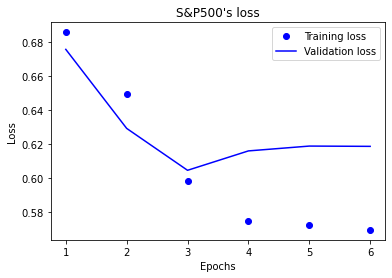

In [132]:
 plt.plot(epochs,loss_values,'bo',label='Training loss')
plt.plot(epochs,val_loss_values,'b',label='Validation loss')
plt.title("{}'s loss".format(인덱스명))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

,영업일,인덱스,상승예측확률,실제수익률
0,1~20일 차,KOSPI,0.9933,-0.002441
0,1~20일 차,KOSDAQ,0.0025,0.003883
0,1~20일 차,NASDAQ,0.9570,0.131118
0,1~20일 차,HSI,0.9999,-0.121905
0,1~20일 차,S&P500,0.0067,0.119830
...,...,...,...,...
0,661~680일 차,KOSPI,0.3496,-0.155708
0,661~680일 차,KOSDAQ,0.0000,-0.210812
0,661~680일 차,NASDAQ,0.9999,-0.048450
0,661~680일 차,HSI,1.0000,-0.117972


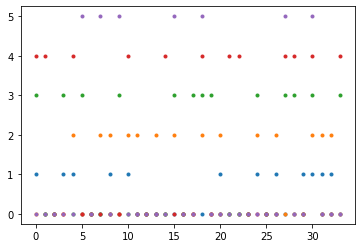

In [127]:
plt.plot(그래프용["KOSPI"],'.')
plt.plot(그래프용["KOSDAQ"],'.')
plt.plot(그래프용["NASDAQ"],'.')
plt.plot(그래프용["HSI"],'.')
plt.plot(그래프용["S&P500"],'.')

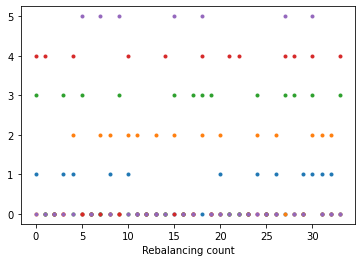

In [128]:
plt.plot(그래프용2["KOSPI"],'.')
plt.plot(그래프용2["KOSDAQ"],'.')
plt.plot(그래프용2["NASDAQ"],'.')
plt.plot(그래프용2["HSI"],'.')
plt.plot(그래프용2["S&P500"],'.')
plt.xlabel("Rebalancing count")

fig = plt.gcf()
fig.savefig('oo.png', dpi=fig.dpi)

In [68]:
총df[-20:].to_csv("hi.csv",encoding="UTF-8")

In [60]:
KS11

,Close,Open,High,Low,Change
Date,,,,,
2009-01-02,1157.40,1132.87,1157.40,1118.84,0.0293
2009-01-05,1173.57,1180.98,1185.22,1166.66,0.0140
2009-01-06,1194.28,1183.52,1203.59,1179.94,0.0176
2009-01-07,1228.17,1198.85,1228.56,1195.20,0.0284
2009-01-08,1205.70,1212.70,1218.43,1195.15,-0.0183
...,...,...,...,...,...
2018-12-21,2061.49,2052.70,2061.51,2049.76,0.0007
2018-12-24,2055.01,2050.38,2059.94,2046.18,-0.0031
2018-12-26,2028.01,2028.81,2037.83,2014.28,-0.0131


In [102]:


df = KS11

# 특성 추가--------------------------------------------------------


    #스토캐스틱과 이동평균선
df=get_stochastic(df)
df=get_MA(df)
    #RSI
df['Momentum_1D'] = (df['Close']-df['Close'].shift(1))
df['RSI_14D'] = df['Momentum_1D'].rolling(center=False, window=14).apply(rsi)

df=df.dropna()
df=df[0:-(len(df)%BATCH)]
print("gk0.5",df.shape)
df = df.drop(labels = ['Momentum_1D'], axis=1)
    #이동평균선
MA_26=df["Close"].rolling(21).mean()
df_MA=MA_26.dropna()
df_char=df[20:] # df_char : 특성 모두 추가한 data, rolling,shifting 고려해서 제거
   #------------------------------------------------------------------
print("gk",df_char.shape)



    # y ( target ) 생성 df_char= 값, df_MA= 이동평균선---------------------
y=[]
#20개로 1개 예측
h=1
for x in range(1,len(df_char)+1):
    if(df_char["Close"][x-1] > df_MA[20*h-1]):
        y.append(0)
    else:
        y.append(1)
    if(x%20==0):
        h=h+1

df = df_char[:] 
nparr = df # 스케일링 할 데이터
nparr2 = df # 스케일링 안한 데이터 백업


#-----
#     df["y"]=y
#     print(df.corr()) #상관관계 분석 ( 출력하고 싶다면 주석 제거)
#     df = df.drop(['y'],axis = 1)
#-----

df = df.drop(['Open','High','Low','MA_26','MA_52'], axis = 1 ) # 상관관계 분석 후 관계 적은 특성(열) 제거
X=df
# train test val 세팅
setlen=int(len(X)/20*0.7)*20 # 데이터를 7:3으로 나누고 20의 배수로 만듬
X_train=X[:setlen]
X_test=X[setlen:]
y_train=y[:setlen]
y_test=y[setlen:]

setlen2=int(len(X_train)/20*0.3)*20 # 검증 데이터를 3:7으로 나누고 20의 배수로 만듬
X_val = X_train[ : setlen2]
y_val = y_train[ : setlen2]
X_train2 = X_train[setlen2 : ]
y_train2 = y_train[setlen2 : ]



gk0.5 (2400, 12)
gk (2380, 11)


In [65]:
len(y_test)

660

In [36]:
KS11.shape

(2474, 5)

In [103]:
X_test.shape

(720, 6)

In [95]:
len(그래프용["S&P500"])

35

In [96]:
a=그래프용

In [104]:
a

{'KOSPI': array([0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0]),
 'KOSDAQ': array([0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0]),
 'NASDAQ': array([0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1]),
 'HSI': array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]),
 'S&P500': array([0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1])}

In [139]:
df=X_test["Close"]

In [158]:
for z in ["KOSPI","KOSDAQ","NASDAQ","HSI","S&P500"]:
    don =10000
    for x in range(1,36):
        if a[z][x-1]==1:
            don = don + don * (df[x*20]-df[(x-1)*20])/df[(x-1)*20]
        else:
            continue
    print(don)

8002.74939745866
8613.840574689457
9198.093917075152
9426.371046133248
9233.884251971085


In [156]:
don

8613.840574689457

In [129]:
X_test["Close"][20*x]

2537.15

-14450.210696823591

In [145]:
(df[40]-df[20])/df[20]*10000

268.7468388092542

In [154]:
don

9233.884251971085